In [7]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from statistics import mean
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu
from lib.utils.rmsd import kabsch_rmsd, kabsch_rotate, kabsch_weighted_rmsd, centroid, centroid_weighted, rmsd, rmsd_weighted

# optical vectors import
from lib.optical_vectors.optical_vectors import get_image_cut_coordinates, get_optical_vectors

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

from references.transforms import RandomHorizontalFlip

from lib.utils.visual_utils import *
from lib.matching.matching import *


In [8]:
# load dataset to get a set of poses to match to
ref_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3'), osp.join(project_root,'data/vzf/freestyle/freestyle_4'), osp.join(project_root,'data/vzf/freestyle/freestyle_6')], train=False)

test_dataset_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_1')]

test_dataset = PoseDataset(test_dataset_dirs, train=False)

## Load csv file with displacements


In [9]:
dataset_root = test_dataset_dirs[0]
cut_dict = get_image_cut_coordinates(dataset_root)

print(cut_dict.keys())

dict_keys(['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '2

tensor(124, dtype=torch.int32)


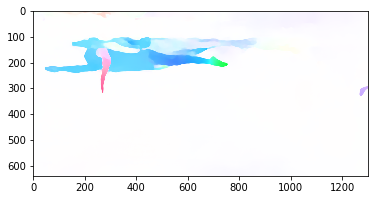

In [20]:
test_id = 8
test_img, test_target = test_dataset[test_id]
test_kps = merge_head(test_target['keypoints'][0].detach().numpy())

img_id = test_target['image_id']
print(img_id)

opt_vec = get_optical_vectors(dataset_root, img_id, cut_dict, plot=True)

In [43]:
print(opt_vec.shape)
print(opt_vec[5,5])
print(tensor_to_numpy_image(test_img).shape)

# the image before being processed by flownet had been cropped in the center to ensure dimesions dividable by 64

def get_padded(opt_vec, co):
    # assume that all images will have been cropped horizontally from 672 -> 640 (for out dataset)

    return opt_vec[-16 + co[0], co[1]]

def get_vec_kernel(opt_vec, co, size=(5,5), cut_off=2):
    total_vec = [0,0]
    num = 0
    for i in range(co[0] - size[0]//2, co[0] + size[0]//2 + 1):
        for j in range(co[1] - size[1]//2, co[1] + size[1]//2 + 1):
            try:
                vec = get_padded(opt_vec, [i,j])
            except Exception as e:
                print(e)
            if sqrt(vec[0]**2 + vec[1]**2) > cut_off:
                total_vec[0] += vec[0]
                total_vec[1] += vec[1]
                num += 1
    
    return np.array(total_vec)/num


(640, 1300, 2)
[-0.44099528  0.27816975]
(672, 1300, 3)


[[213. 190.   1.]
 [249. 169.   1.]
 [246. 227.   1.]
 [299. 202.   1.]
 [165. 235.   1.]
 [276. 305.   1.]
 [ 55. 236.   1.]
 [430. 181.   1.]
 [444. 235.   1.]
 [551. 208.   1.]
 [567. 195.   1.]
 [701. 211.   1.]
 [681. 138.   1.]]


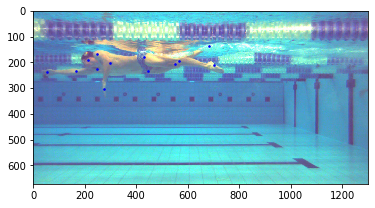

In [44]:
plot_image_with_kps(test_img, [test_kps])
print(test_kps)

In [48]:

# beware the order of the axis:
# kps : horizontal_axis, vertical axis, vis
# img_tensor/opt_vect: vertical axis, horizontal axis
def warp_kps_hard(kps, opt_vec):
    kps_warped = []

    for kp in kps:
        x_co = kp[0]
        y_co = kp[1]
        vis = kp[2]
        #print('xco {}'.format(int(x_co)))
        #print('yco {}'.format(int(y_co)))
        kp_vec = get_vec_kernel(opt_vec, [int(y_co), int(x_co)], size=(20,20))
        print(kp_vec)
        #kp_vec = opt_vec[int(y_co), int(x_co)]
        #print(kp_vec)

        kps_warped.append([x_co + kp_vec[0], y_co + kp_vec[1], vis])

    return np.array(kps_warped)

In [49]:
kps_warped = warp_kps_hard(test_kps, opt_vec)
print(test_kps)
print(kps_warped)


[-10.41221694  -1.45218797]
[-5.63574463 -1.09769013]
[-11.59069991  -1.38137319]
[-2.44191484 -1.79306563]
[-10.66004897  -1.15850287]
[ 9.01333772 -1.22964168]
[-8.93327689 -1.62301439]
[-10.10071629  -1.73831041]
[-9.90303138 -1.21802152]
[-10.94887955  -6.2766579 ]
[-10.44286739  -5.29842261]
[-12.10996988   4.97209667]
[-3.3952237  -2.21404038]
[[213. 190.   1.]
 [249. 169.   1.]
 [246. 227.   1.]
 [299. 202.   1.]
 [165. 235.   1.]
 [276. 305.   1.]
 [ 55. 236.   1.]
 [430. 181.   1.]
 [444. 235.   1.]
 [551. 208.   1.]
 [567. 195.   1.]
 [701. 211.   1.]
 [681. 138.   1.]]
[[202.58778306 188.54781203   1.        ]
 [243.36425537 167.90230987   1.        ]
 [234.40930009 225.61862681   1.        ]
 [296.55808516 200.20693437   1.        ]
 [154.33995103 233.84149713   1.        ]
 [285.01333772 303.77035832   1.        ]
 [ 46.06672311 234.37698561   1.        ]
 [419.89928371 179.26168959   1.        ]
 [434.09696862 233.78197848   1.        ]
 [540.05112045 201.7233421    1.   

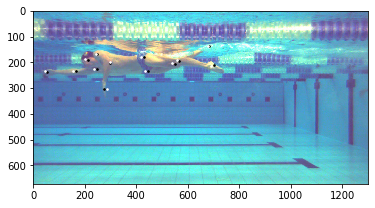

In [50]:
plot_image_with_kps(test_img, [test_kps, kps_warped], ['k','w'])

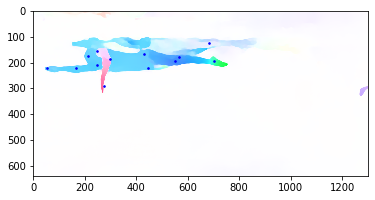

In [37]:
plot_opt_vec(dataset_root, img_id, cut_dict, [test_kps])

In [55]:


def plot_opt_vec(dataset_root, img_id, coordinate_dict, kps_list, color_list=['b', 'r', 'g']):
    try:
        img_id = int(img_id.item())
    except:
        pass
    img_id = str(img_id)
    cut_co = coordinate_dict[img_id]
    flo_url = osp.join(dataset_root,'stitched_optical_vectors', str(img_id).zfill(6) + '.flo')

    fig, ax = plt.subplots()

    vis = fz.convert_from_file(flo_url)
    plt.imshow(vis[:,cut_co[0]:cut_co[0]+cut_co[1]])

    for kps, clr in zip(kps_list, color_list):
        ax.scatter(0 + np.array(kps)[:,0],-16 + np.array(kps)[:,1], s=10, marker='.', c=clr)

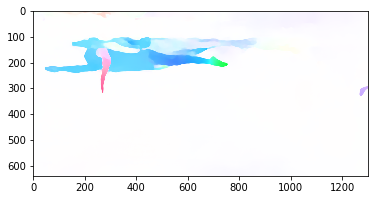

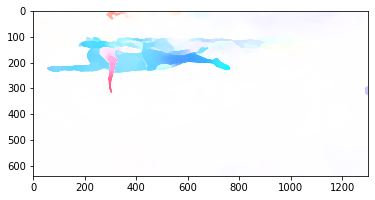

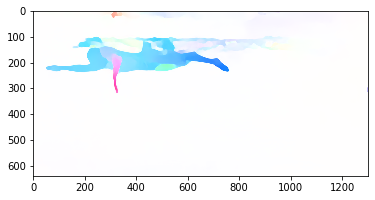

In [60]:
plot_opt_vec(dataset_root, int(img_id.item()), cut_dict, [])
plot_opt_vec(dataset_root, int(img_id.item()) + 1, cut_dict, [])
plot_opt_vec(dataset_root, int(img_id.item()) + 2, cut_dict, [])
